In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map

import cmocean as cm

In [24]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [146]:
adcpfile = '../../../SWOT_Cruise/Signature1000/BB23_W310_VEL_BM_ENU_stacked.nc'

ds=xr.open_dataset(adcpfile)
###
# Input parameters
c = 0.6
z= -8
rotation = 50
t1,t2 = '2023-05-09 02:15:00','2023-05-09 03:00:00' # Big mode-2
# t1,t2 = '2023-04-25 16:00:00','2023-04-25 19:00:00' # Before May-5
# t1,t2 = '2023-04-26 04:00:00','2023-04-26 08:00:00'
# 2023-05-05 10:49:07 W310 pressure jolt
# t1,t2 = '2023-05-05 06:00:00','2023-05-05 15:00:00'
# t1,t2 = '2023-05-04 06:00:00','2023-05-04 15:00:00' # day before
# t1,t2 = '2023-05-07 01:00:00','2023-05-07 04:00:00'
# t1,t2 = '2023-05-24 05:00:00','2023-05-24 07:00:00'

ds = ds.sel(time=slice(t1,t2))

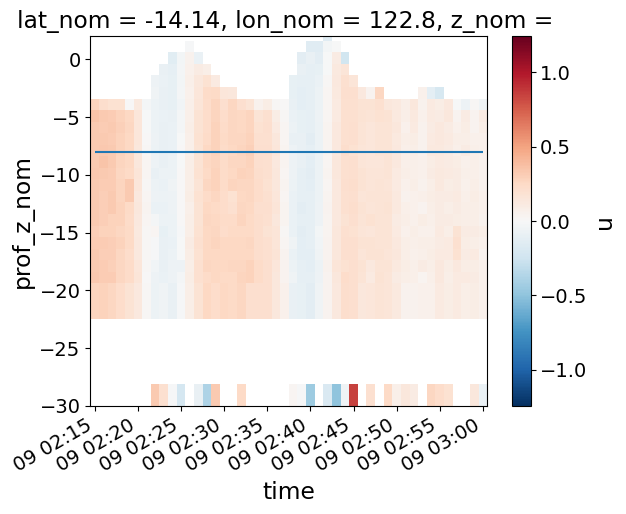

In [137]:
ds['u'].plot()
plt.ylim(-30,2)
plt.hlines(z, ds['time'][0], ds['time'][-1])

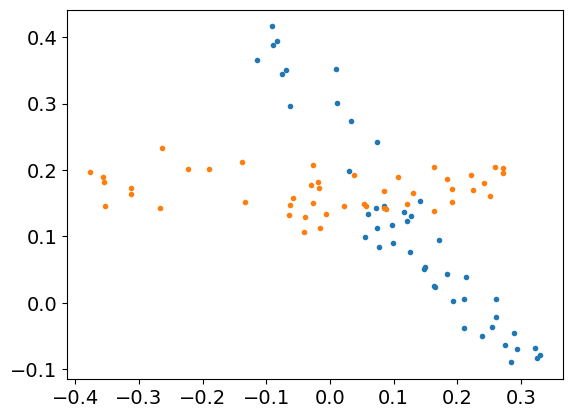

In [138]:
myds = ds.sel(prof_z_nom=z, method='nearest')

Z = myds['u'] +1j*myds['v']
spd, dirn = np.abs(Z), np.angle(Z)
dirn += rotation*np.pi/180

u_r = spd*np.cos(dirn)
v_r = spd*np.sin(dirn)

plt.plot(myds['u'], myds['v'],'.')
plt.plot(u_r, v_r,'.')

In [139]:
myds2 = ds.sel(prof_z_nom=z-1, method='nearest')
Z = myds2['u'] +1j*myds2['v']
spd, dirn = np.abs(Z), np.angle(Z)
dirn += rotation*np.pi/180

u_r2 = spd*np.cos(dirn)
v_r2 = spd*np.sin(dirn)

dudz = u_r-u_r2/1


#plt.plot(dudz)
w = 0.5*(myds2['w']+myds['w'])
w_dudz = w*dudz

In [140]:
tsec = ds.time.values.astype(float)*1e-9
tsec -= tsec[0]


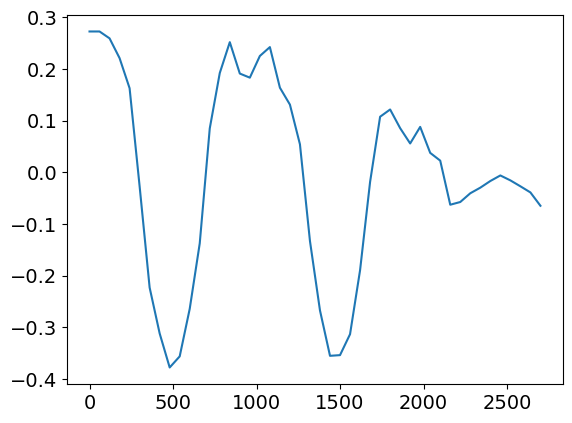

In [141]:
plt.plot(tsec, u_r)

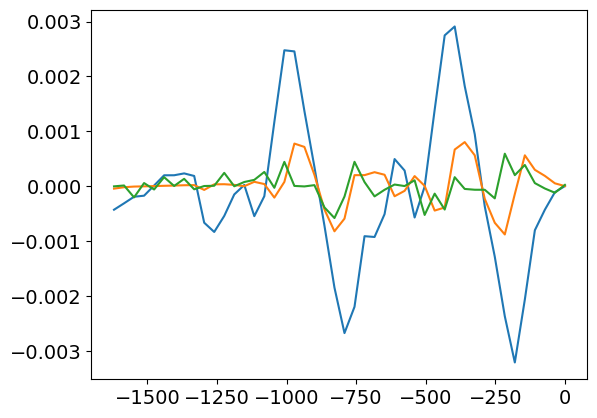

In [142]:
dt = tsec[1] - tsec[0]
dudt = np.gradient(u_r, dt)

x = -c*tsec

dudx = -1/c * dudt
u_dudx = u_r*dudx

plt.plot(x, dudt)
plt.plot(x, u_dudx)
plt.plot(x, w_dudz)

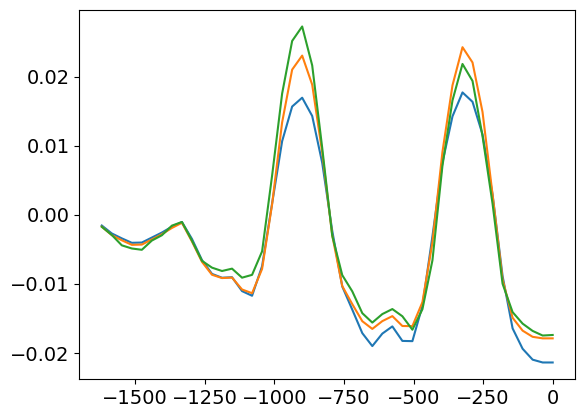

In [143]:
dx = -c*dt # Check the sign!!
eta_1 = -1/9.81 * np.cumsum(dudt[::-1]* dx)[::-1]
eta_2 = -1/9.81 * np.cumsum((dudt+u_dudx)[::-1]* dx)[::-1]
eta_3 = -1/9.81 * np.cumsum((dudt+u_dudx+w_dudz)[::-1]* dx)[::-1]

# eta_1 = -1/9.81 * np.cumsum(dudt* dx)
# eta_2 = -1/9.81 * np.cumsum((dudt+u_dudx)* dx)

plt.plot(x, eta_1)
plt.plot(x, eta_2)
plt.plot(x, eta_3)


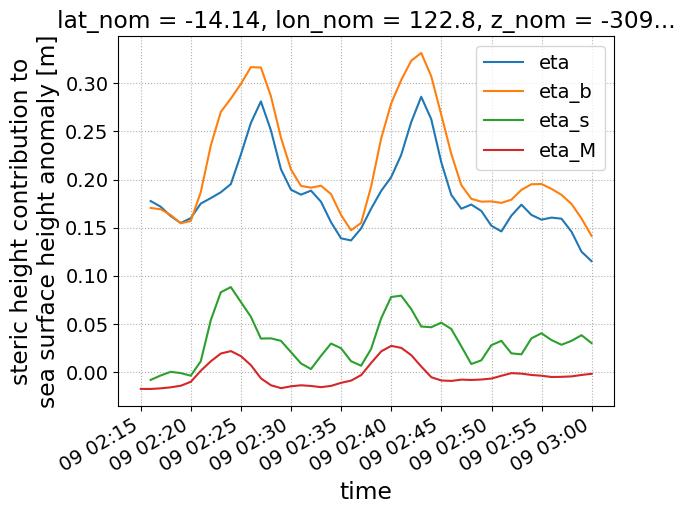

In [144]:
# Compare w/ pressure
mooring = 'W310'
# mooring = 'S245'
# version = 'v2' # FES2014
version = 'v3' # FES2022

mooring_file = f'~/data/ProjectsActive/SWOT_NAust/DATA/mooring_sealevel_{mooring}_{version}.nc'
ds_mooring = xr.open_dataset(mooring_file).sel(time=slice(t1,t2))
eta_b = ds_mooring['eta_b'] - ds_mooring['eta_tide_fes']
eta_insitu = ds_mooring['eta'] - ds_mooring['eta_tide_fes']
eta_insitu.plot(label='eta')
eta_b.plot(label='eta_b')
ds_mooring['eta_steric'].plot(label='eta_s')

plt.plot(ds['time'], eta_3, label='eta_M')
plt.legend()
plt.grid(True, ls=':')

In [102]:
sitename = 'W310'
# ds_bpr = xr.open_dataset('../../../SWOT_Cruise/FV01/RBRqu/[BB23]_[BB23_REC]_[W310]_[48]_[RBRquartz TP]_[213895]_[no_outfile_append].nc')
ds_bpr = xr.open_dataset('../../../SWOT_Cruise/FV01/RBRqu/[BB23]_[BB23_REC]_[W310]_[48]_[RBRquartz TP]_[213895]_[no_outfile_append]_corrected.nc')

ds_1Hz = ds_bpr.isel(time=slice(None,None,16)).sel(time=slice(t1,t2))

Text(0, 0.5, 'T')

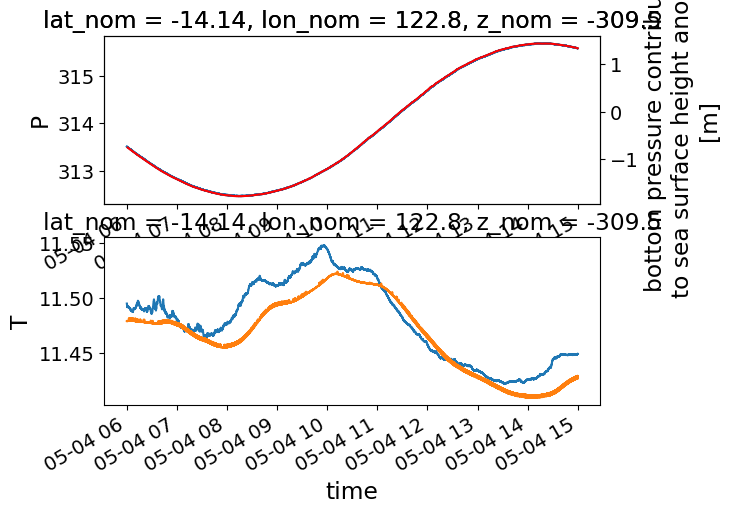

In [103]:
ax=plt.subplot(211)
ds_1Hz['BPR_Pressure'].plot()
ax.twinx()
ds_mooring['eta_b'].plot(c='r')
#ds_mooring['eta_steric'].plot()
#plt.plot(ds['time'], eta_3, c='r')

ax.set_ylabel('P')

ax=plt.subplot(212)
ds_1Hz['Temperature'].plot()
ds_1Hz['BPR_Temperature'].plot()
ax.set_ylabel('T')

# Look at the ADCP pressure and heading data

In [147]:
# t1,t2 = '2023-04-21 03:00:00','2023-05-31'
adcpfile2 = '../../../SWOT_Cruise/FV01/Sentinel/[BB23]_[BB23_REC]_[W310]_[3201]_[Sentinel]_[20089]_[no_outfile_append].nc'

ds_adcp = xr.open_dataset(adcpfile2).sel(time=slice(t1,t2))

ds_adcp


<xarray.Dataset>
Dimensions:              (time: 46, distance: 57, beam: 4, dir: 4, x: 4, x*: 4,
                          earth: 3, inst: 3)
Coordinates:
  * time                 (time) datetime64[ns] 2023-05-09T02:15:00 ... 2023-0...
  * dir                  (dir) int64 1 2 3 4
  * distance             (distance) float64 2.97 3.47 3.97 ... 29.97 30.47 30.97
  * beam                 (beam) int64 1 2 3 4
  * x                    (x) int64 1 2 3 4
  * x*                   (x*) int64 1 2 3 4
  * earth                (earth) object 'E' 'N' 'U'
  * inst                 (inst) object 'X' 'Y' 'Z'
    lat_nom              float64 ...
    lon_nom              float64 ...
    z_nom                float64 ...
    prof_z_nom           (distance) float64 ...
Data variables: (12/32)
    number               (time) uint32 ...
    builtin_test_fail    (time) bool ...
    c_sound              (time) float32 ...
    depth                (time) float32 ...
    pitch                (time) float32 ...
    roll                 (time) float32 ...
    ...                   ...
    vinst                (distance, time) float64 ...
    winst                (distance, time) float64 ...
    errvel               (distance, time) float64 ...
    qc_velocity          (distance, time) float64 ...
    sidelobe_last_good   (time) datetime64[ns] ...
    sidelobe_blank       (distance, time) bool ...
Attributes: (12/35)
    title:                           Measured data from a TDRI ADCP
    institution:                     The University of Western Australia
    institution_division:            Ocean Dynamics
    source:                          pIMOS
    project:                         BB23
    history:                         
    ...                              ...
    nominal_instrument_height_asb:   32.019
    nominal_instrument_orientation:  down
    timezone:                        UTC
    process_level:                   1
    is_profile_data:                 0
    pimos_nickname:                  Sentinel

Text(0, 0.5, 'eta_b [m]')

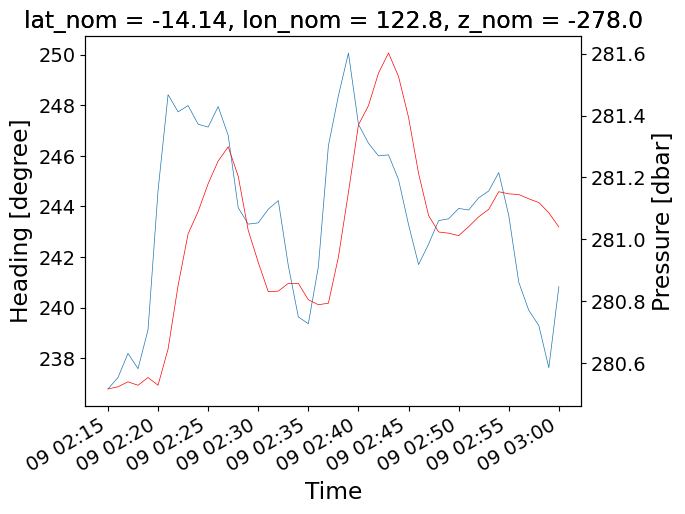

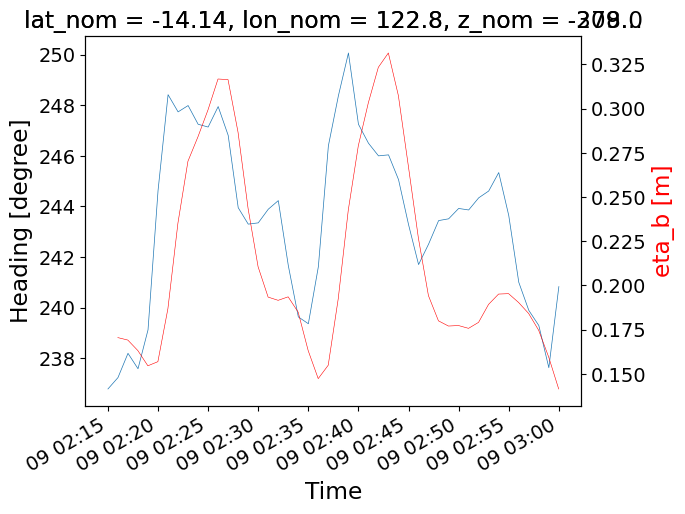

In [150]:
fig, ax = plt.subplots()

ds_adcp['heading'].plot(lw=0.5)
ax.twinx()
ds_adcp['pressure'].plot(c='r', lw=0.5)

fig, ax = plt.subplots()
ds_adcp['heading'].plot(lw=0.5)
ax=ax.twinx()
eta_b.plot(c='r', lw=0.4)
ax.set_ylabel('eta_b [m]', color='r')

Text(0, 0.5, 'mooring rotations')

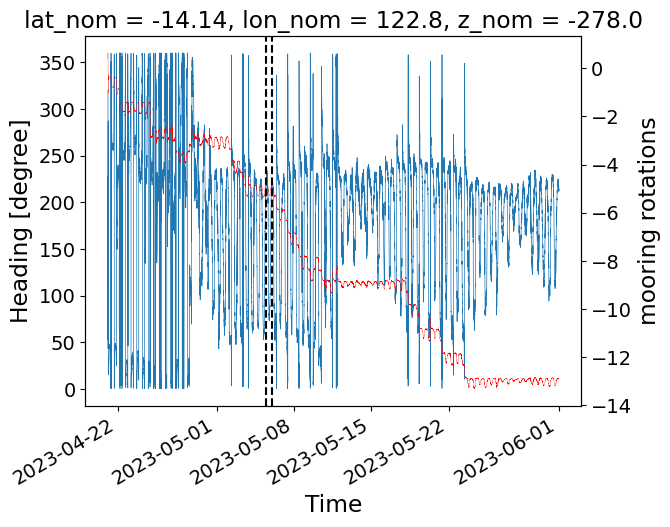

In [145]:
heading_unwrap = np.unwrap(ds_adcp['heading']*np.pi/180 - np.pi)#, period=360, discont=180)

fig, ax = plt.subplots()
ds_adcp['heading'].plot(lw=0.5)
ax2=ax.twinx()
plt.plot(ds_adcp['time'], heading_unwrap/(2*np.pi), lw=0.2, c='r')
ax.axvline(np.datetime64('2023-05-05 10:49:07'),color='black',linestyle='--')
ax.axvline(np.datetime64('2023-05-06 00:51:09'),color='black',linestyle='--')
ax2.set_ylabel('mooring rotations')